In [32]:
import copy
import os
import time
import random
import sys
import warnings

import numpy as np
import pandas as pd
from typing import Any


from hyperimpute.plugins.imputers import Imputers
from hyperimpute.utils.distributions import enable_reproducible_results
from hyperimpute.utils.benchmarks import compare_models
import hyperimpute.logger as log


from IPython.display import HTML, display
import tabulate

import json

warnings.filterwarnings("ignore")
enable_reproducible_results()

imputers = Imputers()
log.add(sink=sys.stderr, level="INFO")

# Plots

In [33]:
#!pip install xlrd
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris
from scipy import signal


def smooth_line(src: list) -> list:
    return signal.savgol_filter(src, 3, 1)


X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame=True, return_X_y=True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "airfoil": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        header=None,
        sep="\\t",
    ),
    "blood": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
    ),
    "bc": X_raw_breast_cancer,
    "california": X_raw_california,
    "climate": climate_model_df,
    "compression": pd.read_excel(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    ),
    "slump": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data"
    ),
    "sonar": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
        header=None,
    ),
    "diabetes": X_raw_diab,
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "iris": X_raw_iris,
    "libras": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",
        sep=",",
        header=None,
    ),
    "parkinsons": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",
        sep=",",
    ),
    "yacht": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",
        sep="\s+",
        header=None,
    ),
    "ionosphere": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",
        sep=",",
        header=None,
    ),
    "letter": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
        header=None,
    ),
    "spam": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    ),
    "credit": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data",
        header=None,
    ),
}

In [47]:
# Parse results

import pandas as pd
import numpy as np
from pathlib import Path
import json
import pandas as pd

experiment = "plots_raw/MCAR"
results = Path(experiment).glob("*")

remap_models = {
    "Our method": "hyperimpute",
    "Evaluated: hyperimpute": "hyperimpute",
    "sklearn_missforest": "missforest",
    "sklearn_ice": "ice",
}
norm_cols = [
    "Our method",
    "mean",
    "sklearn_missforest",
    "sklearn_ice",
    "gain",
    "sinkhorn",
    "softimpute",
]

rmse_key = "Mean RMSE"
wass_key = "Mean Wasserstein distance"
pred_key = "Mean downstream prediction error"

data = {}

df_names =  [
    "airfoil",
    "blood",
    "california",
    "compression",
    "diabetes",
    "ionosphere",
    "iris",
    "letter",
    "libras",
    "spam",
    "wine_red",
    "wine_white"
]


def generate_mean_std(data, headers):
    _mean = []
    _std = []

    for scenario in data:
        local_mean = []
        local_std = []
        for vals in scenario:
            if isinstance(vals, list):
                local_mean.append(vals[0])
                local_std.append(vals[1])
            else:
                local_mean.append(vals)
                local_std.append(vals)
        _mean.append(local_mean)
        _std.append(local_std)
    _mean_df = pd.DataFrame(_mean, columns=headers)
    _std_df = pd.DataFrame(_std, columns=headers)

    return _mean_df, _std_df


for res in results:
    if "debug" in res.name:
        continue

    if res.name not in df_names:
        continue

    with open(res) as f:
        local_data = json.load(f)

        headers = local_data["headers"]

        rmse_mean, rmse_std = generate_mean_std(local_data["rmse"], headers)
        distr_mean, distr_std = generate_mean_std(local_data["wasserstein"], headers)

    data[res.name] = {
        rmse_key: (rmse_mean, rmse_std),
        wass_key: (distr_mean, distr_std),
    }


results = {}
models_cnt = len(headers) - 2
df_names = sorted(data.keys())

for dataset in df_names:
    for metric in data[dataset]:
        df, df_std = data[dataset][metric]

        # Prediction norm
        num_df = df._get_numeric_data()
        num_df[num_df <= 0] = 1e-6

        for scenario in ["MAR", "MCAR", "MNAR"]:
            if scenario not in results:
                results[scenario] = {}

            for miss in [0.1, 0.3, 0.5, 0.7]:
                if miss not in results[scenario]:
                    results[scenario][miss] = {}

                local_df = df[df["Scenario"] == scenario].drop(columns=["Scenario"])
                local_df = local_df[local_df["miss_pct [0, 1]"] == miss].drop(
                    columns=["miss_pct [0, 1]"]
                )

                local_df = local_df.rename(columns=remap_models)

                if len(local_df) == 0:
                    continue

                local_df_std = df_std[df_std["Scenario"] == scenario].drop(
                    columns=["Scenario"]
                )
                local_df_std = local_df_std[
                    local_df_std["miss_pct [0, 1]"] == miss
                ].drop(columns=["miss_pct [0, 1]"])

                local_df_std = local_df_std.rename(columns=remap_models)

                if metric not in results[scenario][miss]:
                    results[scenario][miss][metric] = {}
                for col in local_df.columns:
                    if col not in results[scenario][miss][metric]:
                        results[scenario][miss][metric][col] = {
                            "mean": [],
                            "std": [],
                        }
                    results[scenario][miss][metric][col]["mean"].append(
                        min(local_df[col].values[0], 0.5)
                    )
                    results[scenario][miss][metric][col]["std"].append(
                        min(local_df_std[col].values[0], 0.01)
                    )

## General overview

In [48]:
output_dir = Path(f"diagrams_{experiment}")
output_dir.mkdir(parents=True, exist_ok=True)

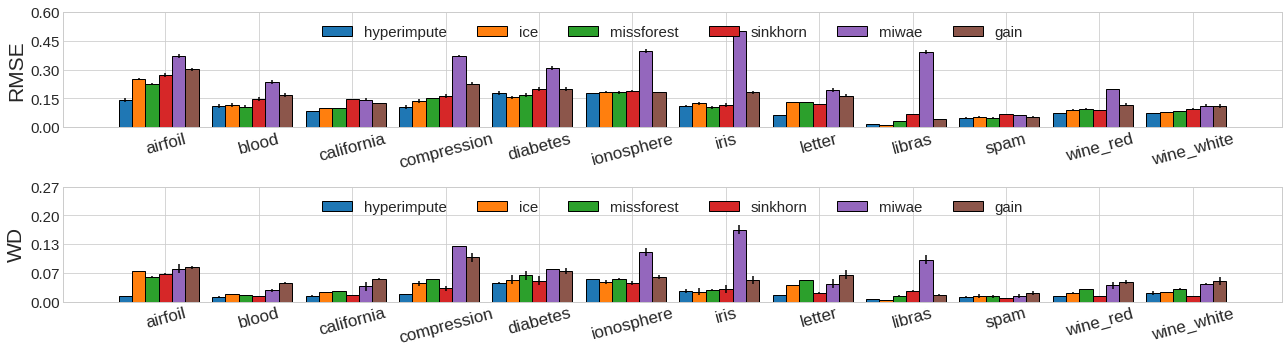

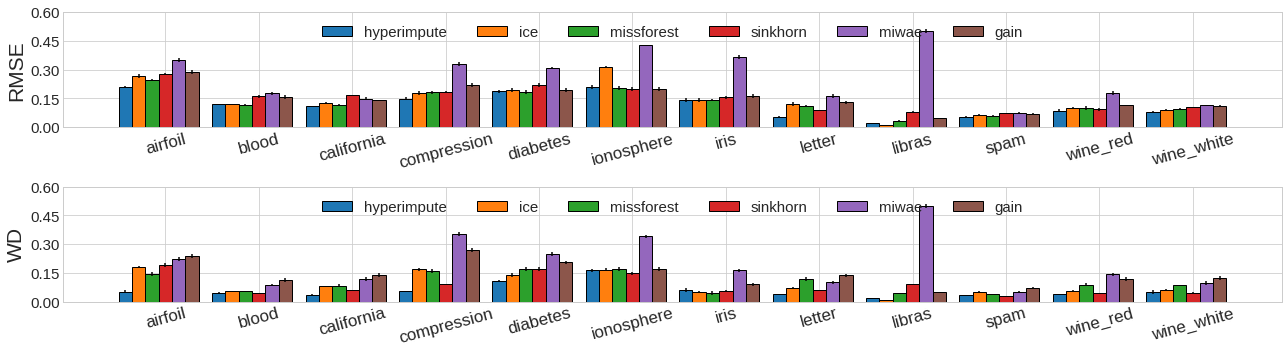

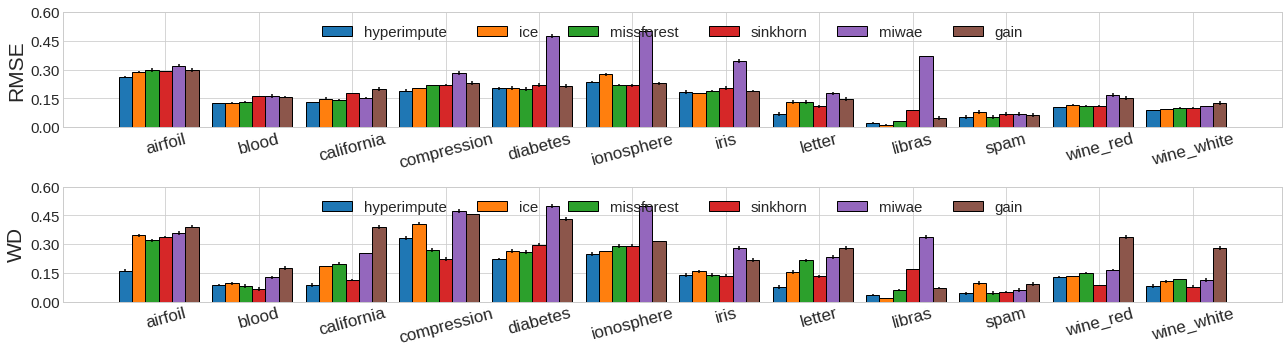

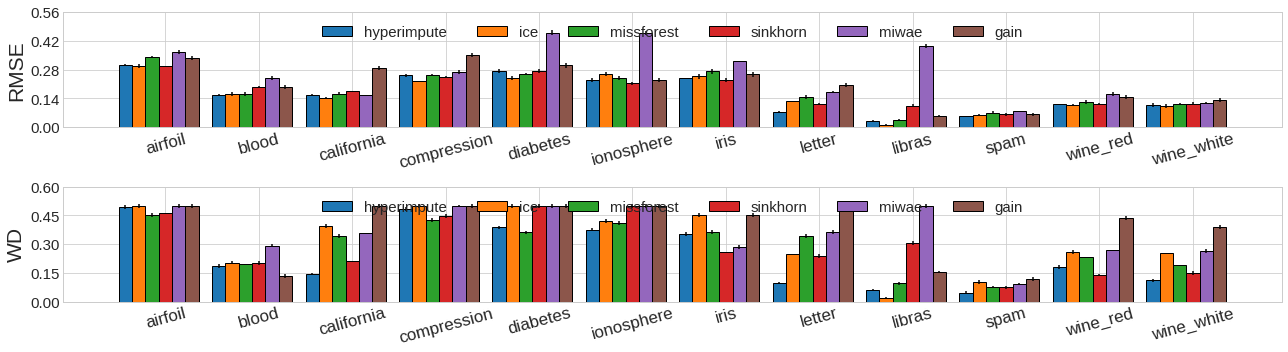

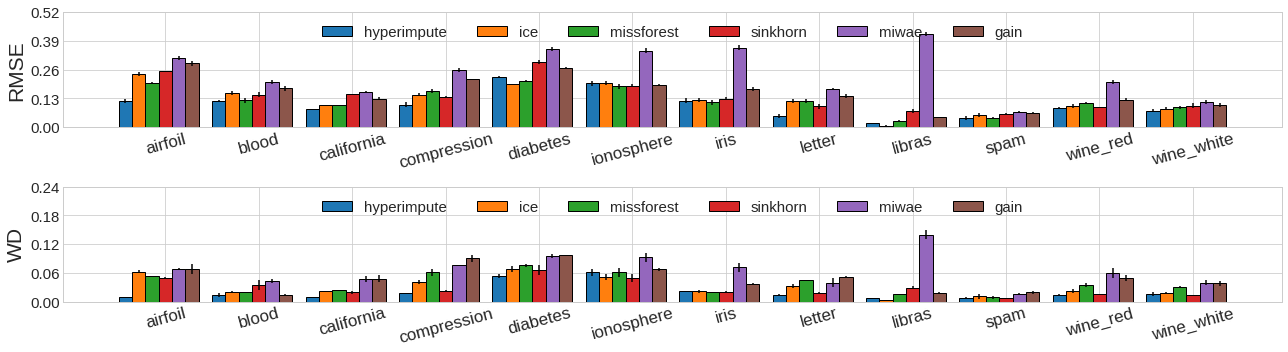

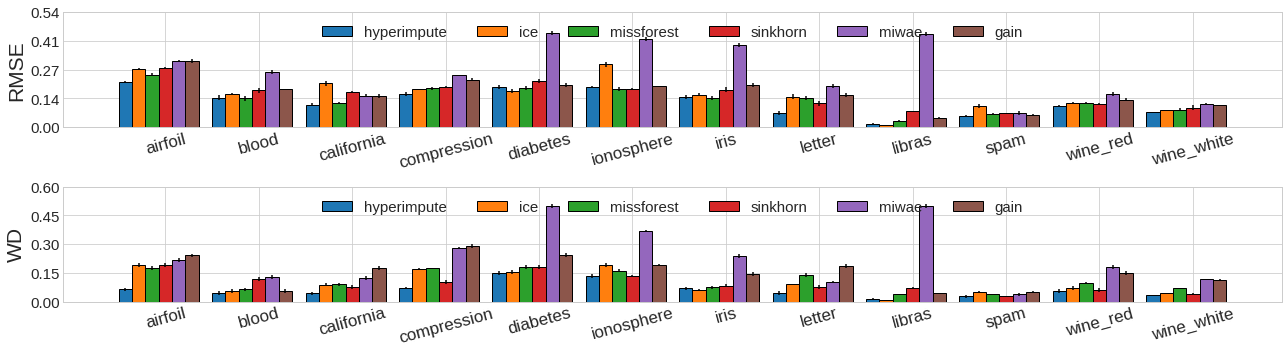

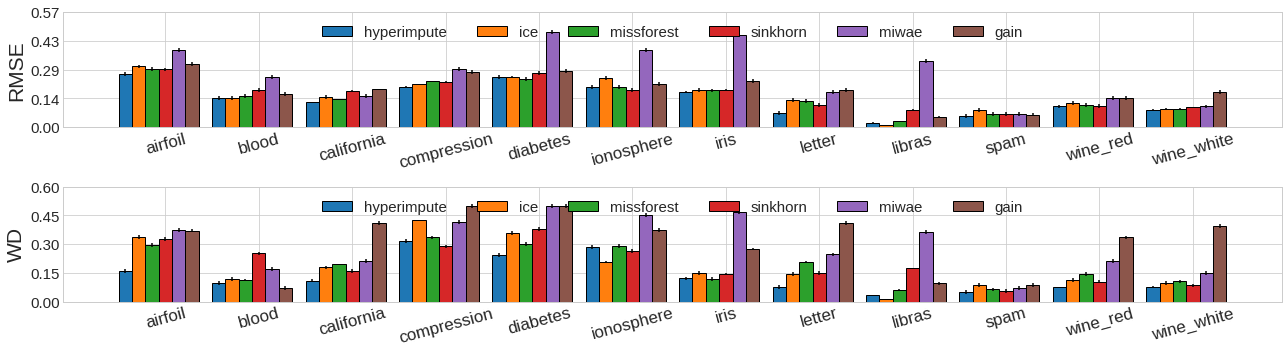

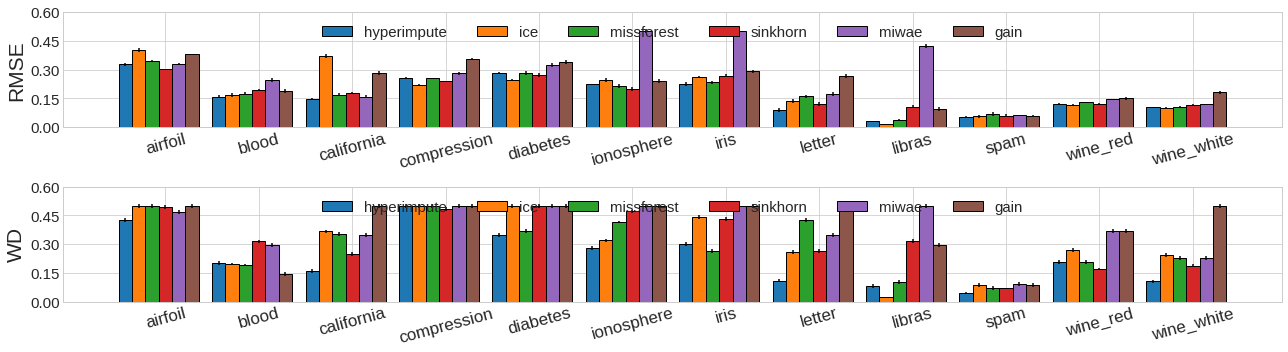

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fontsize = 15
df_graph_len = models_cnt + 1


def generate_plot_for_ax(ax, scenario, miss, metric):
    offset = len(data)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    barWidth = 1

    max_val = 0
    idx = 0
    for model in results[scenario][miss][metric]:
        pos = [idx + df_graph_len * i * barWidth for i in range(offset)]

        if len(pos) == 0:
            continue

        mod_mean = results[scenario][miss][metric][model]["mean"]
        mod_std = results[scenario][miss][metric][model]["std"]
        if max_val < max(mod_mean):
            max_val = max(mod_mean)

        ax.bar(
            pos,
            mod_mean,
            yerr=mod_std,
            width=barWidth,
            label=str(model),
            edgecolor="k",
        )
        idx += barWidth

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=models_cnt,
        prop={"size": fontsize},
    )

    ax.set_xticks(
        [df_graph_len * r + int(models_cnt / 2) for r in range(offset)],
        df_names,
        rotation=15,
        fontsize=fontsize+2,
    )
    ax.set_yticks(np.linspace(0, max_val + 0.1, num=5), fontsize=fontsize+2)
    if metric == 'Mean RMSE':
        ylabel = 'RMSE'
        ax.set_ylabel(ylabel, fontsize=fontsize + 6)
    if metric == 'Mean Wasserstein distance':
        ylabel = 'WD'
        ax.set_ylabel(ylabel, fontsize=fontsize + 6)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    return ax


def generate_plot(scenario, miss):
    plt.style.use("seaborn-whitegrid")

    offset = len(data)
    metrics = list(results[scenario][miss].keys())
    fig, axs = plt.subplots(len(metrics), figsize=(18, 5))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax(axs[idx], scenario, miss, metric)

#     plt.xlabel(f"{scenario} simulation with {miss} missingness", fontsize=fontsize)
    plt.subplots_adjust(hspace=0.35)
    plt.tight_layout()
    
    plt.savefig(output_dir / f"general_overview_{scenario}_{miss}.png", bbox_inches='tight')
    plt.show()


for scenario in ["MCAR", "MNAR"]:
    for miss in [0.1, 0.3, 0.5, 0.7]:
        generate_plot(scenario, miss)